
# Verbmobil Small – ASR Evaluation

Dieses Notebook fasst die Erkennungsleistung der beiden aktuell angebundenen ASR-Pipelines über das `verbmobil_small`-Korpus zusammen. Es setzt voraus, dass du zuvor die Inferenz via

```bash
python main.py verbmobil_small --model both
```

ausgeführt hast (ggf. mit angepassten Batch-Größen), sodass die Resultate als CSV im konfigurierten `OUTPUT_PATH` vorliegen.



## Setup & Daten laden

Wir lesen die Ergebnisse aus dem `OUTPUT_PATH` (oder dem Standardordner `outputs/`), prüfen die wichtigsten Spalten und verschaffen uns einen ersten Überblick über die Datenmenge.


In [2]:

from __future__ import annotations

import os
from pathlib import Path
from typing import Final

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv

sns.set_theme(style="whitegrid")
load_dotenv()

OUTPUT_PATH = os.getenv("OUTPUT_PATH")
OUTPUT_DIR: Final[Path] = Path(OUTPUT_PATH) if OUTPUT_PATH else Path("outputs")
DATASET_CSV: Final[Path] = OUTPUT_DIR / "verbmobil_small.csv"

print(f"OUTPUT_DIR: {OUTPUT_DIR}")
print(f"CSV-Datei: {DATASET_CSV}")

if not DATASET_CSV.is_file():
    raise FileNotFoundError(
        "Keine Verbmobil-Ergebnisse gefunden. Führe zuerst `python main.py verbmobil_small --model both` aus "
        "oder passe den Pfad an."
    )

raw_df = pd.read_csv(DATASET_CSV)
raw_df.head()


OUTPUT_DIR: /Volumes/T7 Touch/Experimente/aibay
CSV-Datei: /Volumes/T7 Touch/Experimente/aibay/verbmobil_small.csv


,utterance_id,conversation_id,speaker_code,turn_index,channel,audio_path,gt_transcription,gt_transcription_raw,whisper_large_v3_transcription,whisper_large_v3_segments,whisper_large_v3_wer
0,1G071A:HAH001A,1G071A,HAH,1.0,A,/nfs/data/VM_base/DATA/SSG/1G071A:HAH001A,ja also für den eintägigen wenn wir den als er...,"ja also f""ur den eint""agigen wenn_wir den als ...","Ja, also für den Eintägigen, wenn wir den als ...","[{'timestamp': (0.0, 7.52), 'text': ' Ja, also...",0.047619
1,1G071A:HAH003A,1G071A,HAH,3.0,A,/nfs/data/VM_base/DATA/SSG/1G071A:HAH003A,ja am ersten ist Allerheiligen da ist wohl nic...,ja am ersten ist Allerheiligen da ist wohl nic...,"Ja, am 1. ist Allerheiligen, da ist wohl nicht...","[{'timestamp': (0.0, 6.68), 'text': ' Ja, am 1...",0.136364
2,1G071A:HAH005A,1G071A,HAH,5.0,A,/nfs/data/VM_base/DATA/SSG/1G071A:HAH005A,nee da muß ich leider zu einem Treffen nach Kö...,"nee da mu""s ich_leider zu einem Treffen nach K...","Nee, da muss ich leider zu einem Treffen nach ...","[{'timestamp': (0.0, 1.86), 'text': ' Nee, da ...",0.114286
3,1G071A:HAH007A,1G071A,HAH,7.0,A,/nfs/data/VM_base/DATA/SSG/1G071A:HAH007A,ja bitte das wäre mir sehr recht wenn ich 'ne ...,"ja bitte das_w""are mir_sehr recht wenn ich 'ne...","Ja, bitte, das wäre mir sehr recht. Wenn ich e...","[{'timestamp': (0.0, 7.08), 'text': ' Ja, bitt...",10.440000
4,1G071A:HAH009A,1G071A,HAH,9.0,A,/nfs/data/VM_base/DATA/SSG/1G071A:HAH009A,gut dann hätten wir noch mal ein zweitägiges T...,"gut dann h""atten wir noch mal ein zweit""agiges...","Gut, dann hätten wir noch mal ein zweitägiges ...","[{'timestamp': (0.0, 14.16), 'text': ' Gut, da...",0.190476


In [3]:

row_count = len(raw_df)
present_columns = sorted(raw_df.columns)

print(f"Zeilen (Segments): {row_count:,}")
print("Verfügbare Spalten:")
for col in present_columns:
    print(f"  - {col}")


Zeilen (Segments): 15,188
Verfügbare Spalten:
  - audio_path
  - channel
  - conversation_id
  - gt_transcription
  - gt_transcription_raw
  - speaker_code
  - turn_index
  - utterance_id
  - whisper_large_v3_segments
  - whisper_large_v3_transcription
  - whisper_large_v3_wer



## WER-Überblick

Wir fokussieren uns auf die Word Error Rate (WER) der Whisper- und Parakeet-Ausgaben. Zusätzlich wird – sofern beide Modelle vorhanden sind – die Differenz betrachtet, um Stärken/Schwächen pro Segment zu identifizieren.


In [4]:

WER_COLUMNS = [
    "whisper_large_v3_wer",
    "parakeet_tdt_v3_wer",
]

available_wer = [col for col in WER_COLUMNS if col in raw_df.columns]
if not available_wer:
    raise ValueError("Keine WER-Spalten gefunden. Stelle sicher, dass die Inferenz erfolgreich durchlief.")

summary_rows: list[dict[str, float]] = []
for col in available_wer:
    series = raw_df[col].dropna()
    if series.empty:
        continue
    summary_rows.append(
        {
            "metric": col,
            "count": int(series.count()),
            "mean": float(series.mean()),
            "median": float(series.median()),
            "std": float(series.std()),
            "p10": float(series.quantile(0.10)),
            "p90": float(series.quantile(0.90)),
            "min": float(series.min()),
            "max": float(series.max()),
        }
    )

wer_summary = pd.DataFrame(summary_rows)
wer_summary


,metric,count,mean,median,std,p10,p90,min,max
0,whisper_large_v3_wer,15167,4.673186,0.1875,16.62561,0.0,14.8,0.0,310.0


/var/folders/6l/kwcycbvx6hv5sw6sz8qf8xk00000gn/T/ipykernel_66678/529239452.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_df, x="modell", y="wer", palette="muted")


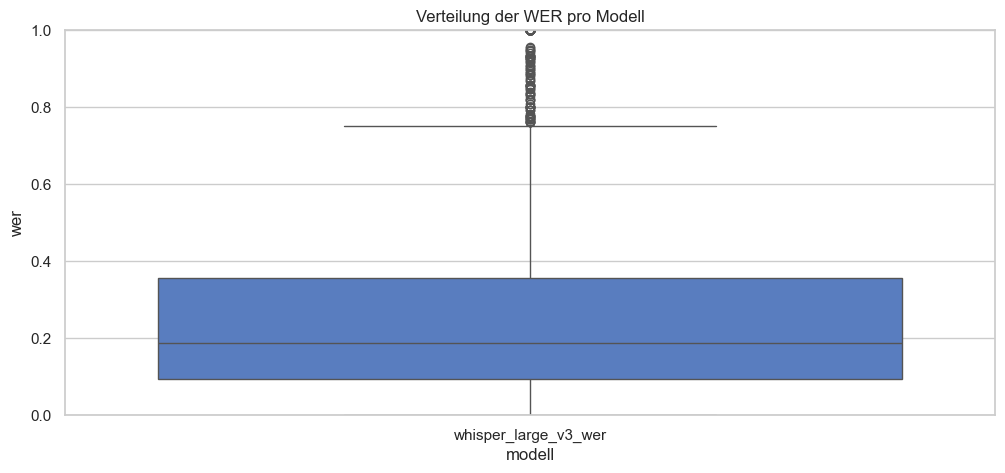

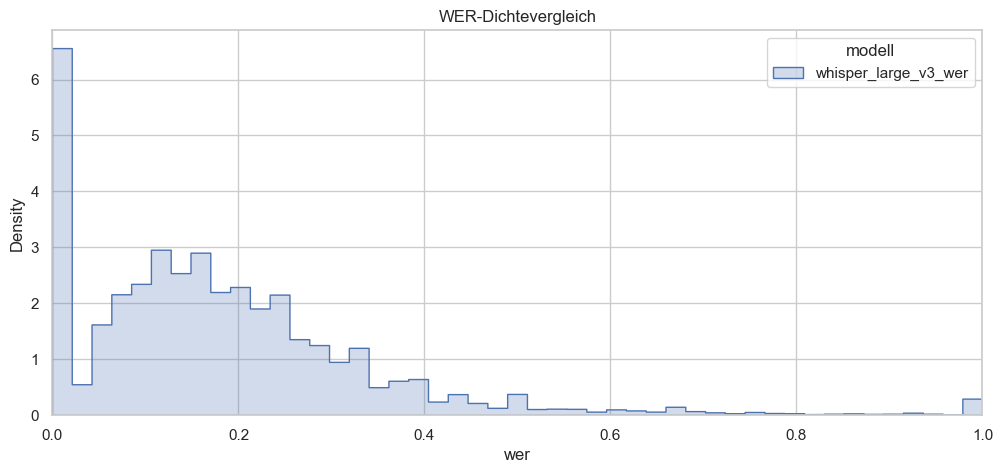

In [5]:

plot_df = raw_df.copy()
plot_df = plot_df.melt(
    value_vars=[col for col in WER_COLUMNS if col in plot_df.columns],
    var_name="modell",
    value_name="wer",
)
plot_df = plot_df.dropna(subset=["wer"])

if plot_df.empty:
    raise ValueError("Keine gültigen WER-Werte zum Plotten verfügbar.")

plt.figure(figsize=(12, 5))
sns.boxplot(data=plot_df, x="modell", y="wer", palette="muted")
plt.title("Verteilung der WER pro Modell")
plt.ylim(0, min(1.0, plot_df["wer"].max() * 1.05))
plt.show()

plt.figure(figsize=(12, 5))
sns.histplot(data=plot_df, x="wer", hue="modell", element="step", stat="density", common_norm=False)
plt.title("WER-Dichtevergleich")
plt.xlim(0, min(1.0, plot_df["wer"].max() * 1.05))
plt.show()



## Segment-Highlights

Zur Einordnung, welche Sequenzen besonders herausfordernd sind, listen wir die zehn höchsten WER-Differenzen auf. Positive Werte bedeuten, dass Parakeet schlechter als Whisper abschneidet, negative Werte deuten auf einen Vorteil für Parakeet.


In [6]:

if "whisper_large_v3_wer" in raw_df.columns and "parakeet_tdt_v3_wer" in raw_df.columns:
    diff_df = raw_df.dropna(subset=["whisper_large_v3_wer", "parakeet_tdt_v3_wer"]).copy()
    diff_df["wer_diff_parakeet_minus_whisper"] = diff_df["parakeet_tdt_v3_wer"] - diff_df["whisper_large_v3_wer"]

    highlight_columns = []
    for candidate in ("utterance_id", "conversation_id", "speaker_code", "channel"):
        if candidate in diff_df.columns:
            highlight_columns.append(candidate)
    highlight_columns.extend([
        "wer_diff_parakeet_minus_whisper",
        "whisper_large_v3_wer",
        "parakeet_tdt_v3_wer",
    ])

    worst_segments = diff_df.nlargest(10, "wer_diff_parakeet_minus_whisper")[highlight_columns]
    best_segments = diff_df.nsmallest(10, "wer_diff_parakeet_minus_whisper")[highlight_columns]

    display(worst_segments)
    display(best_segments)
else:
    print("Für Segmentvergleiche werden beide WER-Spalten benötigt.")


Für Segmentvergleiche werden beide WER-Spalten benötigt.



## Weiterführende Schritte

- Ergänze bei Bedarf eigene Filter (z. B. nach Sprecher*in oder Kanal) und exportiere Teilmengen zur manuellen Qualitätsprüfung.
- Nutze `python recompute_wer.py <csv>` für aktualisierte WERs nach manuellen Transkriptanpassungen.
- Die Batch-Parameter `--whisper-batch-size` und `--parakeet-batch-size` steuern die Geschwindigkeit der Inferenz.
